In [ ]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK

def create_sequences(input_data, output_data, time_steps):
    X, y = [], []
    for i in range(len(input_data) - time_steps):
        v = input_data[i:(i + time_steps)]
        X.append(v)
        y.append(output_data[i + time_steps])
    return np.array(X), np.array(y)


df = pd.read_csv('/content/drive/MyDrive/Weather/41.9N_12.46E.csv')
df.columns = ['year', 'month', 'day', 'hour', 'temperature', 'precipitation', 'u-wind', 'v-wind']
df.temperature = df.temperature - 273.15
df['date'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
df.set_index('date', inplace=True)
df['date'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])

hours_in_day = 24
days_in_month = 30
months_in_year = 12
df['hour_sin'] = np.sin(2 * np.pi * df['date'].dt.hour / hours_in_day)
df['hour_cos'] = np.cos(2 * np.pi * df['date'].dt.hour / hours_in_day)
df['day_sin'] = np.sin(2 * np.pi * df['date'].dt.day / days_in_month)
df['day_cos'] = np.cos(2 * np.pi * df['date'].dt.day / days_in_month)
df['month_sin'] = np.sin(2 * np.pi * df['date'].dt.month / months_in_year)
df['month_cos'] = np.cos(2 * np.pi * df['date'].dt.month / months_in_year)

columns_to_drop = ['date','month','day','hour','year']
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns], axis=1)
winter_months = [12,1,2]
df_winter = df[df.index.month.isin(winter_months)]

X = df_winter[['precipitation', 'u-wind', 'v-wind', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos']].values
y = df_winter['temperature'].values

scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)


X_train = X[-2014*24:-(24*7*2)-10]
y_train = y[-2014*24:(-24*7*2)-10]
X_val = X[-24*7*2:(-24*7)-10]
y_val = y[-24*7*2:(-24*7)-10]
X_test = X[(-24*7)-10:]
y_test = y[(-24*7)-10:]

time_steps = 10
X_train_seq, y_train_seq = create_sequences(X_train, y_train, time_steps)
X_val_seq, y_val_seq = create_sequences(X_val, y_val, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, time_steps)

input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])

# hyperparameter space
space = {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.001), np.log(0.1))
}

# Objective function LSTM
def lstm_objective(space):
    model = Sequential([
        LSTM(16, return_sequences=True, input_shape=(time_steps, X_train_seq.shape[2])),
        Dropout(0.2),
        LSTM(16),
        Dense(1)
    ])
    optimizer = Adam(learning_rate=space['learning_rate'])
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    early_stop = EarlyStopping(monitor='loss', patience=5, mode='min')
    model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=32, callbacks=[early_stop], verbose=1)

    loss = model.evaluate(X_train_seq, y_train_seq, verbose=0)
    return {'loss': loss, 'status': STATUS_OK}

# Run optimizer
trials = Trials()
best = fmin(fn=lstm_objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)

print("Best learning rate:", best['learning_rate'])






Streaming output truncated to the last 5000 lines.
1500/1500 [==============================] - 15s 10ms/step - loss: 2.1386

Epoch 40/50

1500/1500 [==============================] - 15s 10ms/step - loss: 2.1293

Epoch 41/50

1500/1500 [==============================] - 17s 11ms/step - loss: 2.1156

Epoch 42/50

1500/1500 [==============================] - 16s 11ms/step - loss: 2.1155

Epoch 43/50

1500/1500 [==============================] - 16s 11ms/step - loss: 2.1006

Epoch 44/50

1500/1500 [==============================] - 17s 11ms/step - loss: 2.0990

Epoch 45/50

1500/1500 [==============================] - 15s 10ms/step - loss: 2.0863

Epoch 46/50

1500/1500 [==============================] - 15s 10ms/step - loss: 2.0770

Epoch 47/50

1500/1500 [==============================] - 15s 10ms/step - loss: 2.0684

Epoch 48/50

1500/1500 [==============================] - 17s 11ms/step - loss: 2.0574

Epoch 49/50

1500/1500 [==============================] - 15s 10ms/step - loss: 2.

In [ ]:
!pip install hyperopt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.3/491.3 kB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 kB 20.4 MB/s eta 0:00:00


Epoch 1/50
1447/1447 [==============================] - 14s 8ms/step - loss: 40.6870 - val_loss: 11.3833
Epoch 2/50
1447/1447 [==============================] - 11s 7ms/step - loss: 13.1855 - val_loss: 9.7351
Epoch 3/50
1447/1447 [==============================] - 11s 8ms/step - loss: 10.6915 - val_loss: 7.4343
Epoch 4/50
1447/1447 [==============================] - 11s 8ms/step - loss: 5.5409 - val_loss: 5.2124
Epoch 5/50
1447/1447 [==============================] - 10s 7ms/step - loss: 3.9855 - val_loss: 5.0700
Epoch 6/50
1447/1447 [==============================] - 10s 7ms/step - loss: 3.5336 - val_loss: 5.1051
Epoch 7/50
1447/1447 [==============================] - 11s 7ms/step - loss: 3.4007 - val_loss: 4.9232
Epoch 8/50
1447/1447 [==============================] - 11s 8ms/step - loss: 3.3667 - val_loss: 4.8765
Epoch 9/50
1447/1447 [==============================] - 11s 7ms/step - loss: 3.3423 - val_loss: 4.9073
Epoch 10/50
1447/1447 [==============================] - 10s 7ms/step

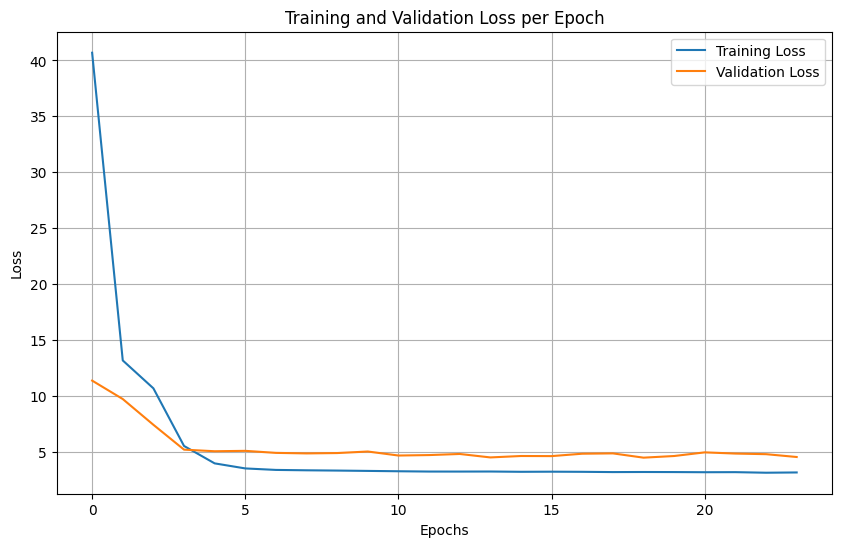

6/6 [==============================] - 1s 4ms/step


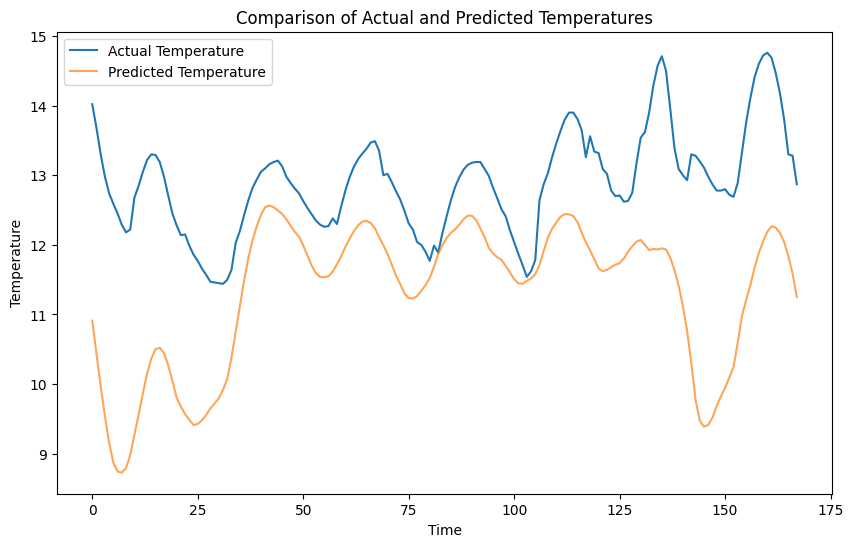

In [ ]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

def create_sequences(input_data, output_data, time_steps):
    X, y = [], []
    for i in range(len(input_data) - time_steps):
        v = input_data[i:(i + time_steps)]
        X.append(v)
        y.append(output_data[i + time_steps])
    return np.array(X), np.array(y)


df = pd.read_csv('/content/drive/MyDrive/Weather/41.9N_12.46E.csv')
df.columns = ['year', 'month', 'day', 'hour', 'temperature', 'precipitation', 'u-wind', 'v-wind']
df.temperature = df.temperature - 273.15
df['date'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
df.set_index('date', inplace=True)
df['date'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])

hours_in_day = 24
days_in_month = 30
months_in_year = 12
df['hour_sin'] = np.sin(2 * np.pi * df['date'].dt.hour / hours_in_day)
df['hour_cos'] = np.cos(2 * np.pi * df['date'].dt.hour / hours_in_day)
df['day_sin'] = np.sin(2 * np.pi * df['date'].dt.day / days_in_month)
df['day_cos'] = np.cos(2 * np.pi * df['date'].dt.day / days_in_month)
df['month_sin'] = np.sin(2 * np.pi * df['date'].dt.month / months_in_year)
df['month_cos'] = np.cos(2 * np.pi * df['date'].dt.month / months_in_year)

columns_to_drop = ['date','month','day','hour','year']
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns], axis=1)
winter_months = [12,1,2]
df_winter = df[df.index.month.isin(winter_months)]

X = df_winter[['precipitation', 'u-wind', 'v-wind', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos']].values
y = df_winter['temperature'].values

scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)


X_train = X[-2014*24:-(24*7*2)-10]
y_train = y[-2014*24:(-24*7*2)-10]
X_val = X[-24*7*2:(-24*7)-10]
y_val = y[-24*7*2:(-24*7)-10]
X_test = X[(-24*7)-10:]
y_test = y[(-24*7)-10:]



time_steps = 10
X_train_seq, y_train_seq = create_sequences(X_train, y_train, time_steps)
X_val_seq, y_val_seq = create_sequences(X_val, y_val, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, time_steps)

input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])

model_LSTM = Sequential([
    LSTM(2, return_sequences=True, input_shape=input_shape),
    Dropout(0.2),
    LSTM(2, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])
optimizer = Adam(learning_rate=0.005996327626540966)
optimizer = Adam(learning_rate=0.0036732180899782486)


model_LSTM.compile(optimizer=optimizer, loss='mean_squared_error')
early_stop = EarlyStopping(monitor='loss', patience=5, mode='min')
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

early_stop = EarlyStopping(monitor='val_loss', patience=5)

history = model_LSTM.fit(X_train_seq, y_train_seq, epochs=50, batch_size=32, validation_split=0.035, callbacks=[early_stop], verbose=1)

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
predictions_LSTM = model_LSTM.predict(X_test_seq).flatten()

rmse_LSTM = np.sqrt(mean_squared_error(y_test_seq, predictions_LSTM))

plt.figure(figsize=(10, 6))
plt.plot(y_test_seq, label='Actual Temperature')
plt.plot(predictions_LSTM, label='Predicted Temperature', alpha=0.7)
plt.title('Comparison of Actual and Predicted Temperatures')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [ ]:
rmse_LSTM

1.8731665722984092

In [ ]:
predictions_LSTM

array([10.910497 , 10.437794 ,  9.966096 ,  9.543707 ,  9.158643 ,
        8.870406 ,  8.745063 ,  8.72703  ,  8.79541  ,  8.979824 ,
        9.27836  ,  9.560822 ,  9.868812 , 10.15007  , 10.367768 ,
       10.502108 , 10.521909 , 10.446447 , 10.270842 , 10.048201 ,
        9.804068 ,  9.677301 ,  9.568752 ,  9.487386 ,  9.411697 ,
        9.427328 ,  9.479851 ,  9.5557   ,  9.650723 ,  9.721422 ,
        9.795737 ,  9.919787 , 10.074569 , 10.382235 , 10.752221 ,
       11.119736 , 11.489457 , 11.814893 , 12.067105 , 12.269056 ,
       12.433737 , 12.542293 , 12.565695 , 12.540489 , 12.494757 ,
       12.444677 , 12.370136 , 12.275885 , 12.188106 , 12.118033 ,
       11.993288 , 11.847237 , 11.703089 , 11.593652 , 11.541059 ,
       11.534921 , 11.550556 , 11.615417 , 11.723431 , 11.8354645,
       11.970846 , 12.088368 , 12.193259 , 12.279107 , 12.333942 ,
       12.345812 , 12.3132715, 12.23644  , 12.111652 , 11.9934   ,
       11.868402 , 11.717187 , 11.557987 , 11.438651 , 11.3018

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
All Correlations:
               -33.9N_18.5E -33.5N_151E 17.36N_78.5E 18N_283.2E  \
-33.9N_18.5E            NaN    0.361475    -0.063007  -0.570198   
-33.5N_151E             NaN         NaN    -0.214383  -0.475408   
17.36N_78.5E            NaN         NaN          NaN   0.018188   
18N_283.2E              NaN         NaN          NaN        NaN   
40.75N_286.01E          NaN         NaN          NaN        NaN   
41.9N_12.46E            NaN         NaN          NaN        NaN   
43.28N_5.39E            NaN         NaN          NaN        NaN   
43.64N_280.63E          NaN         NaN          NaN        NaN   
51.03N_245.94E          NaN         NaN          NaN        NaN   
51.5N_359.9E            NaN         NaN          NaN        NaN   
58.76N_265.83E          NaN         NaN          NaN        NaN   
59.92N_10.75E           NaN         NaN          

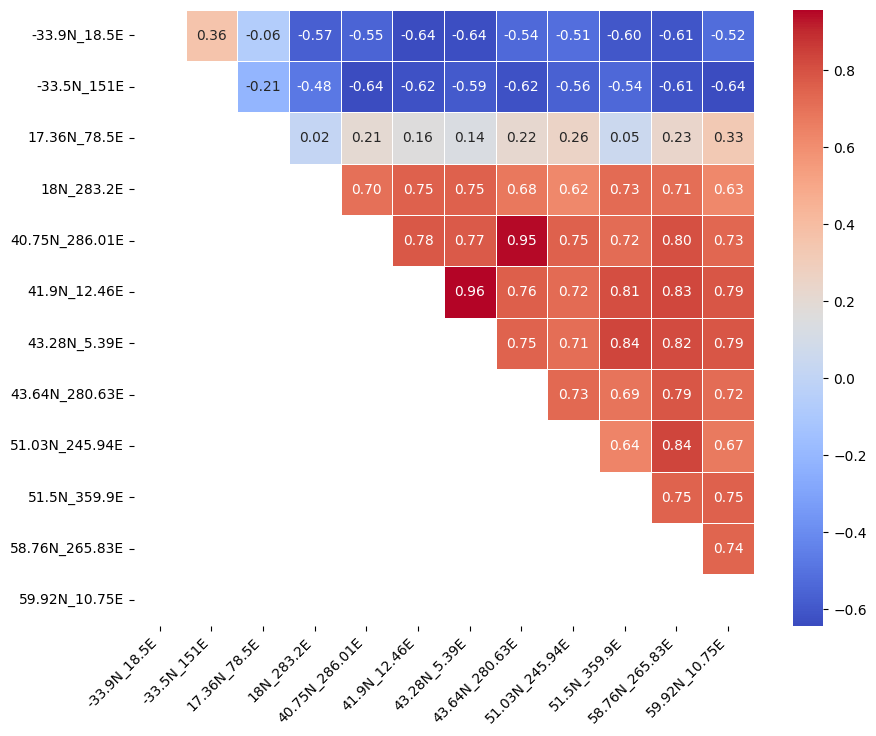

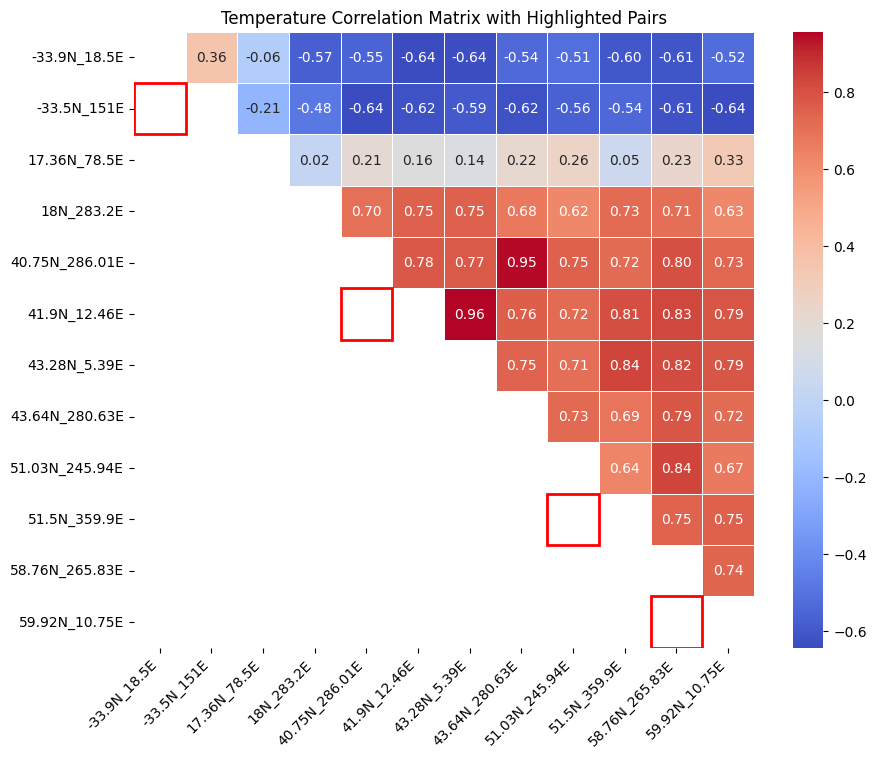